### Package Imports

In [6]:
#Package imports
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import utils
sns.set_style('darkgrid')
from pandas_datareader import data #Package for pulling data from the web
from datetime import date
from fbprophet import Prophet 

### Pulling in Data

In [7]:
#Pulling in the tickers and economic predicators we're interested in
#ONLN = Online Retail ETF, FTXD = Nasdaq Retail ETF, XLY = S&P Consumer Discretionary ETF, 
#IYK iShares US Consumer Goods ETF, AMZN = Amazon, EBAY = Ebay, FB = Facebook
#JETS = Global Airline ETF (Recovery trade), XOP = S&P O&G Exploration and Production ETF (Recovery Trade)
#GOVT = US T-Bond ETF, CL=F = Crude, GC=F = Gold, SI=F = Silver, HG=F = Copper, ^VIX = CBOE Vix
tickers = ['ECOM.V','SPY','ONLN','FTXD','XLY','IYK','AMZN','EBAY','FB','JETS','XOP','GOVT','CL=F','GC=F','SI=F','HG=F','^VIX']

#Getting the most up to date data we can
today = date.today() #This function automatically updates with today's data


#Pulling the timeseries data directly from yahoo finance into a dataframe
etf_df= data.DataReader(tickers, 
                       start='2020-06-01', #start date
                       end = today, #charting up to today's date
                       data_source='yahoo')['Adj Close'] #obtaining price at close

#Dropping missing vals
etf_df = etf_df.dropna()

#Checking the 5 most recent values
etf_df.head(5)

Symbols,ECOM.V,SPY,ONLN,FTXD,XLY,IYK,AMZN,EBAY,FB,JETS,XOP,GOVT,CL=F,GC=F,SI=F,HG=F,^VIX
Date,,,,,,,,,,,,,,,,,
2020-12-15,1.22,366.819824,74.850616,28.408119,158.095337,167.403671,3165.120117,51.915482,275.549988,23.030714,60.658276,27.309750,47.619999,1852.300049,24.580999,3.5380,22.889999
2020-12-16,1.29,367.395508,76.598030,28.472925,159.131775,167.373764,3240.959961,53.480522,275.670013,22.700846,59.845936,27.289810,47.820000,1856.099976,24.985001,3.5540,22.500000
2020-12-17,1.27,369.449982,78.097229,28.660374,160.218048,170.075577,3236.080078,52.882416,274.480011,22.750828,59.845936,27.260872,48.360001,1887.199951,26.100000,3.5970,21.930000
2020-12-18,1.16,367.974792,78.077370,28.623482,159.440720,170.743561,3201.649902,52.892387,276.399994,22.520920,59.063309,27.250893,49.099998,1885.699951,25.948999,3.6285,21.570000
2020-12-21,1.10,366.659088,78.702858,28.619495,157.639572,169.417572,3206.179932,51.407089,272.790009,22.001129,58.038746,27.280828,47.740002,1879.199951,26.278000,3.5730,25.160000


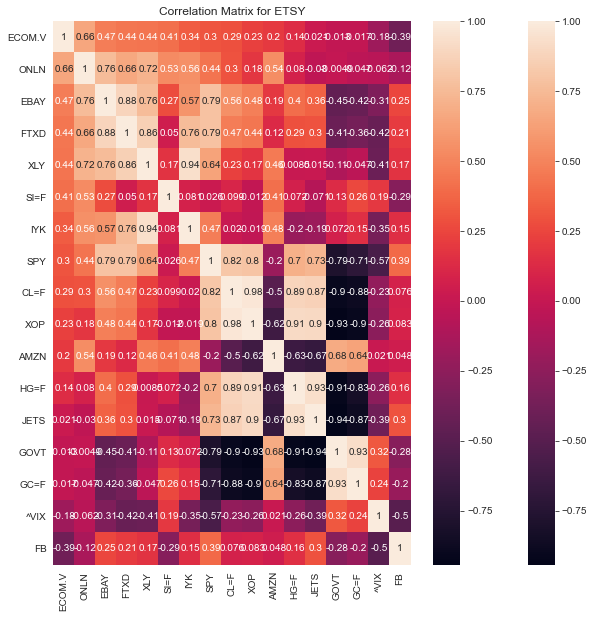

In [8]:
#Creating correlation matrix
corr_mat = etf_df.corr()
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(corr_mat)

#Quantifying the Correlation Matrix
i = 20
columns = corr_mat.nlargest(i,'ECOM.V')['ECOM.V'].index
corrmat = np.corrcoef(etf_df[columns].values.T)
heatmap = sns.heatmap(corrmat,
            cbar=True,
            annot=True, 
            xticklabels = columns.values,
            yticklabels = columns.values)
ax.set_title('Correlation Matrix for ETSY')
plt.show()

### Forecasting Predicator Variables Individually

In [9]:
#Creating dfs to model with

#ONLN, FB, IYK

#Regressor 1 (ONLN)
reg1_prophet = pd.DataFrame()
reg1_prophet['ds'] = etf_df.index
reg1_prophet['y'] = etf_df['ONLN'].values

#Regressor 2 (XOP)
reg2_prophet = pd.DataFrame()
reg2_prophet['ds'] = etf_df.index
reg2_prophet['y'] = etf_df['FB'].values

#Regressor 3 (IYK)
reg3_prophet = pd.DataFrame()
reg3_prophet['ds'] = etf_df.index
reg3_prophet['y'] = etf_df['IYK'].values

### Fitting Models

In [10]:
#Pred 1
reg1_m = Prophet()
reg1_m.fit(reg1_prophet)
reg1_future = reg1_m.make_future_dataframe(freq='m', periods=3);

#Pred 2
reg2_m = Prophet()
reg2_m.fit(reg2_prophet)
reg2_future = reg2_m.make_future_dataframe(freq='m', periods=3);

#Pred 3
reg3_m = Prophet()
reg3_m.fit(reg3_prophet)
reg3_future = reg3_m.make_future_dataframe(freq='m', periods=3);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Creating Forecast for Next 6 Months of Predicator Variables

In [11]:
#Defining length of forecast
future_pred_length = reg1_m.make_future_dataframe(freq='m',periods = 3)

#Pred 1
reg1_forecast = reg1_m.predict(future_pred_length)   
reg1_pred = pd.DataFrame(reg1_forecast['trend'].values)

#Pred 2
reg2_forecast = reg2_m.predict(future_pred_length)
reg2_pred = pd.DataFrame(reg2_forecast['trend'].values)

#Pred 3
reg3_forecast = reg3_m.predict(future_pred_length)
reg3_pred = pd.DataFrame(reg3_forecast['trend'].values)

In [12]:
#Combining predicators into one df
frames = [future_pred_length,reg1_pred,reg2_pred,reg3_pred]
predicator_forecast = pd.concat(frames,axis=1)
predicator_forecast.columns = ['ds','Reg_1','Reg_2','Reg_3']
predicator_forecast.head()

,ds,Reg_1,Reg_2,Reg_3
0,2020-12-15,42.176371,152.727626,93.311097
1,2020-12-16,42.303944,152.440519,93.615304
2,2020-12-17,42.431518,152.153412,93.919511
3,2020-12-18,42.559091,151.866306,94.223718
4,2020-12-21,42.941811,151.004986,95.136338


### Forecasting ETF Performance with Predicator Variables

In [13]:
#Creating dfs to train model with (FB Prophet format)
etf_prophet = pd.DataFrame()
etf_prophet['ds'] = etf_df.index
etf_prophet['y'] = etf_df['ECOM.V'].values
etf_prophet['Reg_1'] = etf_df['ONLN'].values
etf_prophet['Reg_2'] = etf_df['FB'].values
etf_prophet['Reg_3'] = etf_df['IYK'].values

In [14]:
#Checking Prophet df
etf_prophet.head()

,ds,y,Reg_1,Reg_2,Reg_3
0,2020-12-15,1.22,74.850616,275.549988,167.403671
1,2020-12-16,1.29,76.598030,275.670013,167.373764
2,2020-12-17,1.27,78.097229,274.480011,170.075577
3,2020-12-18,1.16,78.077370,276.399994,170.743561
4,2020-12-21,1.10,78.702858,272.790009,169.417572


In [15]:
#Defining model, adding additional regressors and fitting model
m = Prophet()
m.add_regressor('Reg_1')
m.add_regressor('Reg_2')
#m.add_regressor('Reg_3')
m.fit(etf_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
#Forecasting the next 90 days
etf_forecast = m.predict(predicator_forecast) 
etf_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Reg_1,Reg_1_lower,Reg_1_upper,Reg_2,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
69,2021-03-30,0.729613,0.988812,1.223222,0.729613,0.729613,-0.673074,-0.673074,-0.673074,0.442842,...,-0.230232,-0.230232,-0.230232,0.602226,0.602226,0.602226,0.0,0.0,0.0,1.101606
70,2021-03-31,0.729848,0.958897,1.185576,0.729848,0.729848,-0.677366,-0.677366,-0.677366,0.438504,...,-0.238863,-0.238863,-0.238863,0.579847,0.579847,0.579847,0.0,0.0,0.0,1.070832
71,2021-04-30,0.736891,0.671384,0.902012,0.736763,0.737011,-0.806128,-0.806128,-0.806128,0.308363,...,-0.497765,-0.497765,-0.497765,0.553330,0.553330,0.553330,0.0,0.0,0.0,0.792457
72,2021-05-31,0.744170,0.412755,0.655990,0.743774,0.744513,-0.939181,-0.939181,-0.939181,0.173883,...,-0.765298,-0.765298,-0.765298,0.555221,0.555221,0.555221,0.0,0.0,0.0,0.534093
73,2021-06-30,0.751214,0.193482,0.415745,0.750458,0.751881,-1.067943,-1.067943,-1.067943,0.043742,...,-1.024200,-1.024200,-1.024200,0.579847,0.579847,0.579847,0.0,0.0,0.0,0.306861


Text(0.5, 1.0, '3 Month HIMS Forecast [HIMS]')

<Figure size 1440x720 with 0 Axes>

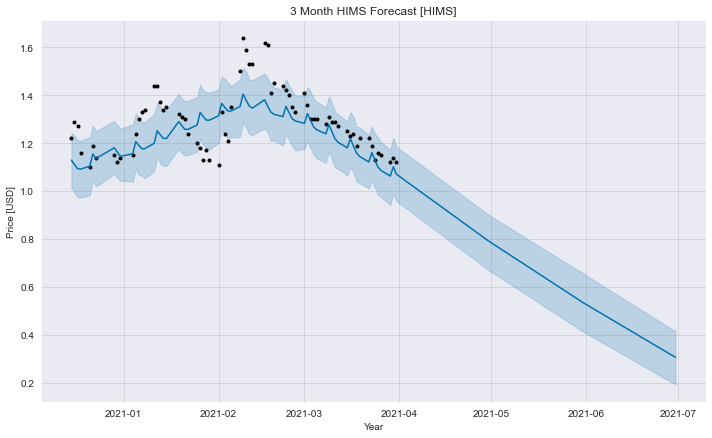

In [18]:
#Visualizing forecast
plt.figure(figsize = (20,10))
m.plot(etf_forecast, xlabel='Year',ylabel ='Price [USD]');
plt.title('3 Month ECOM.V Forecast [ECOM.V]')

<Figure size 1440x720 with 0 Axes>

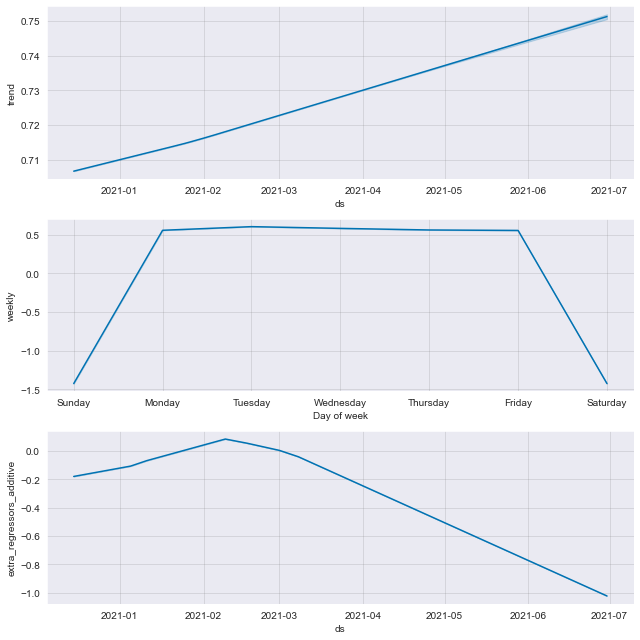

In [19]:
#Plotting forecast components
plt.figure(figsize = (20,10))
m.plot_components(etf_forecast);